In [49]:
from extract_features import process_dataset, load_and_process_sample
from visualization import signal_viewer, plot_signal
from imu_pipeline import IMUPipeline
from pathlib import Path
import pandas as pd
import joblib
import os

In [2]:
signal_viewer(
    data_dir=Path('data/raw/train'),
    labels_csv=Path('data/train.csv')
)

# ❓ Questions to Reflect On


- What do you observe when comparing the model’s predictions on the new data to its known performance?

- Is there anything in the data that might explain differences in behavior?

- Can you identify patterns or trends related to when the model succeeds or fails?

- Are there signals or features that seem to affect the model’s reliability?

- What could be done in the short term to handle the current situation?

- What are potential long-term steps to improve model performance in similar scenarios?

- What would you want to explore further if given more time or data?

- What assumptions did the model rely on during training — and are they still valid?

# ✅ Solution (by Tomer Ben Shimon)



## Model performance analysis

Let's start by analyzing model's performance on the inference data, followed by the test data.
To evaluate the model's performance, I will use several standard metrics: recall, precision, accuracy, F1 score.

We first need to the load labels, inference, and test dataframes (also order them by "sample_id" column to ensure a valid comparison).



In [3]:
labels = pd.read_csv("data/manual_annotation/inference_labels.csv").sort_values(by='sample_id')

In [4]:
labels[['sample_id']].head()

,sample_id
334,0143cf13-fd51-44fd-8dd4-c2c92f5db7bd
9,01b5f718-2978-468f-9789-89003ba755e6
241,01fb46f8-2dc1-4bd3-a823-252a87c3bd03
361,022ae887-3b50-4440-94af-446a1cec3f87
218,02d8b8af-803d-4898-9eb5-51b771e5f2d9


In [5]:
df_inf = pd.read_csv("data/inference.csv").sort_values(by='sample_id')
model = joblib.load("models/imu_pipeline.pkl")

preds = model.predict(df_inf)
probs = model.predict_proba(df_inf)

df_test = pd.read_csv("data/test.csv").sort_values(by='sample_id')
preds_test = model.predict(df_test)

In [6]:
df_inf[['sample_id']].head()

,sample_id
429,0143cf13-fd51-44fd-8dd4-c2c92f5db7bd
186,01b5f718-2978-468f-9789-89003ba755e6
354,01fb46f8-2dc1-4bd3-a823-252a87c3bd03
292,022ae887-3b50-4440-94af-446a1cec3f87
35,02d8b8af-803d-4898-9eb5-51b771e5f2d9


#### Calculate metrics:

In [7]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def calculate_metrics(gt_labels, preds):
    recall = recall_score(gt_labels, preds, average='macro')
    precision = precision_score(gt_labels, preds, average='macro')
    accuracy = accuracy_score(gt_labels, preds)
    f1 = f1_score(gt_labels, preds, average='macro')
    print(f"Recall: {recall:.3f}", f"Precision: {precision:.3f}", f"Accuracy: {accuracy:.3f}", f"F1-Score: {f1:.3f}")
    return np.array([recall, precision, accuracy, f1])

##### Inference metrics:

In [8]:
inf_metrics = calculate_metrics(labels['label'], preds)

Recall: 0.645 Precision: 0.738 Accuracy: 0.645 F1-Score: 0.607


##### Test metrics:

In [9]:
test_metrics = calculate_metrics(df_test['label'], preds_test)

Recall: 0.945 Precision: 0.950 Accuracy: 0.945 F1-Score: 0.945


#### Performance visualization:

In [10]:
import matplotlib.pyplot as plt

def visualize_metric_results(metrics, scores1, scores2, labels):
    x = np.arange(len(metrics))
    width = 0.35

    fig, ax = plt.subplots(figsize=(8, 5))
    rects1 = ax.bar(x - width/2, scores1, width, label=labels[0])
    rects2 = ax.bar(x + width/2, scores2, width, label=labels[1])

    ax.set_ylabel('Score')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    # Add metric values above bars
    for rects in [rects1, rects2]:
        for rect in rects:
            height = rect.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

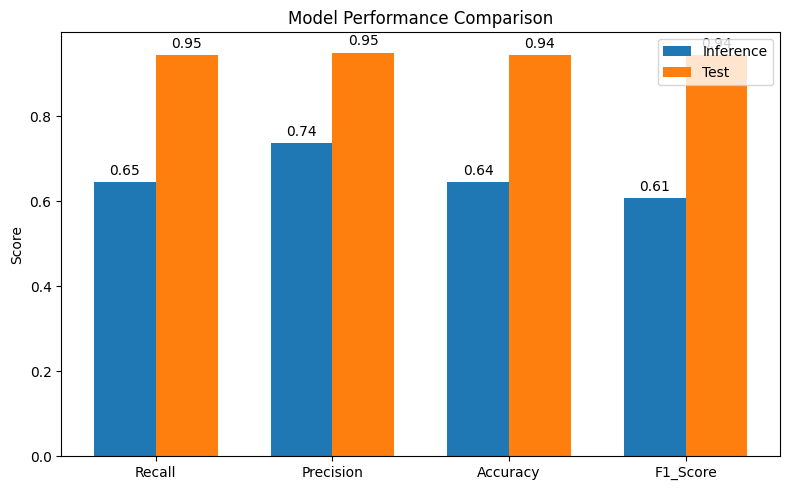

In [11]:
visualize_metric_results(["Recall", "Precision", "Accuracy", "F1_Score"], inf_metrics, test_metrics, ("Inference", "Test"))

### Performance analysis conclusion
- What do you observe when comparing the model’s predictions on the new data to its known performance?
    ##### ✅ Answer: we can clearly observe from both statistical metrics and visualization plots, a significant degradation in the model’s performance - approximately 30% across all metrics when comparing inference results to test results.



&emsp;

## EDA

After identifying the performance discrepancy, let's try to understand its root cause using EDA.

There are several interesting visualizations that could provide insights when comparing the test set to the inference set, including categorical distributions and numerical features.

These visualizations allow us to examine whether there are any discrepancies in feature distributions between the training and test datasets.


#### Category distributions:

In [12]:
def plot_category_distributions(df1, df2, categorical_columns, labels, figure_title="Category Distributions"):
    n = len(categorical_columns)
    cols = 2
    rows = (n + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(12, 5 * rows))
    axes = axes.flatten()

    for i, column in enumerate(categorical_columns):
        ax = axes[i]

        # Count values for both DataFrames
        value_counts1 = df1[column].value_counts()
        value_counts2 = df2[column].value_counts()

        # Combine all categories present in either dataset
        all_categories = sorted(set(value_counts1.index).union(value_counts2.index))

        # Get counts aligned to all categories (fill missing with 0)
        counts1 = [value_counts1.get(cat, 0) for cat in all_categories]
        counts2 = [value_counts2.get(cat, 0) for cat in all_categories]

        # Bar positions
        x = np.arange(len(all_categories))
        width = 0.4

        # Plot bars side by side
        ax.bar(x - width/2, counts1, width, label=labels[0], alpha=0.7)
        ax.bar(x + width/2, counts2, width, label=labels[1], alpha=0.7)

        ax.set_title(f'Distribution of {column}')
        ax.set_xlabel(column)
        ax.set_ylabel('Count')
        ax.set_xticks(x)
        ax.set_xticklabels(all_categories, rotation=45)
        ax.legend()

    fig.suptitle(figure_title, fontsize=16)
    plt.tight_layout()
    plt.show()

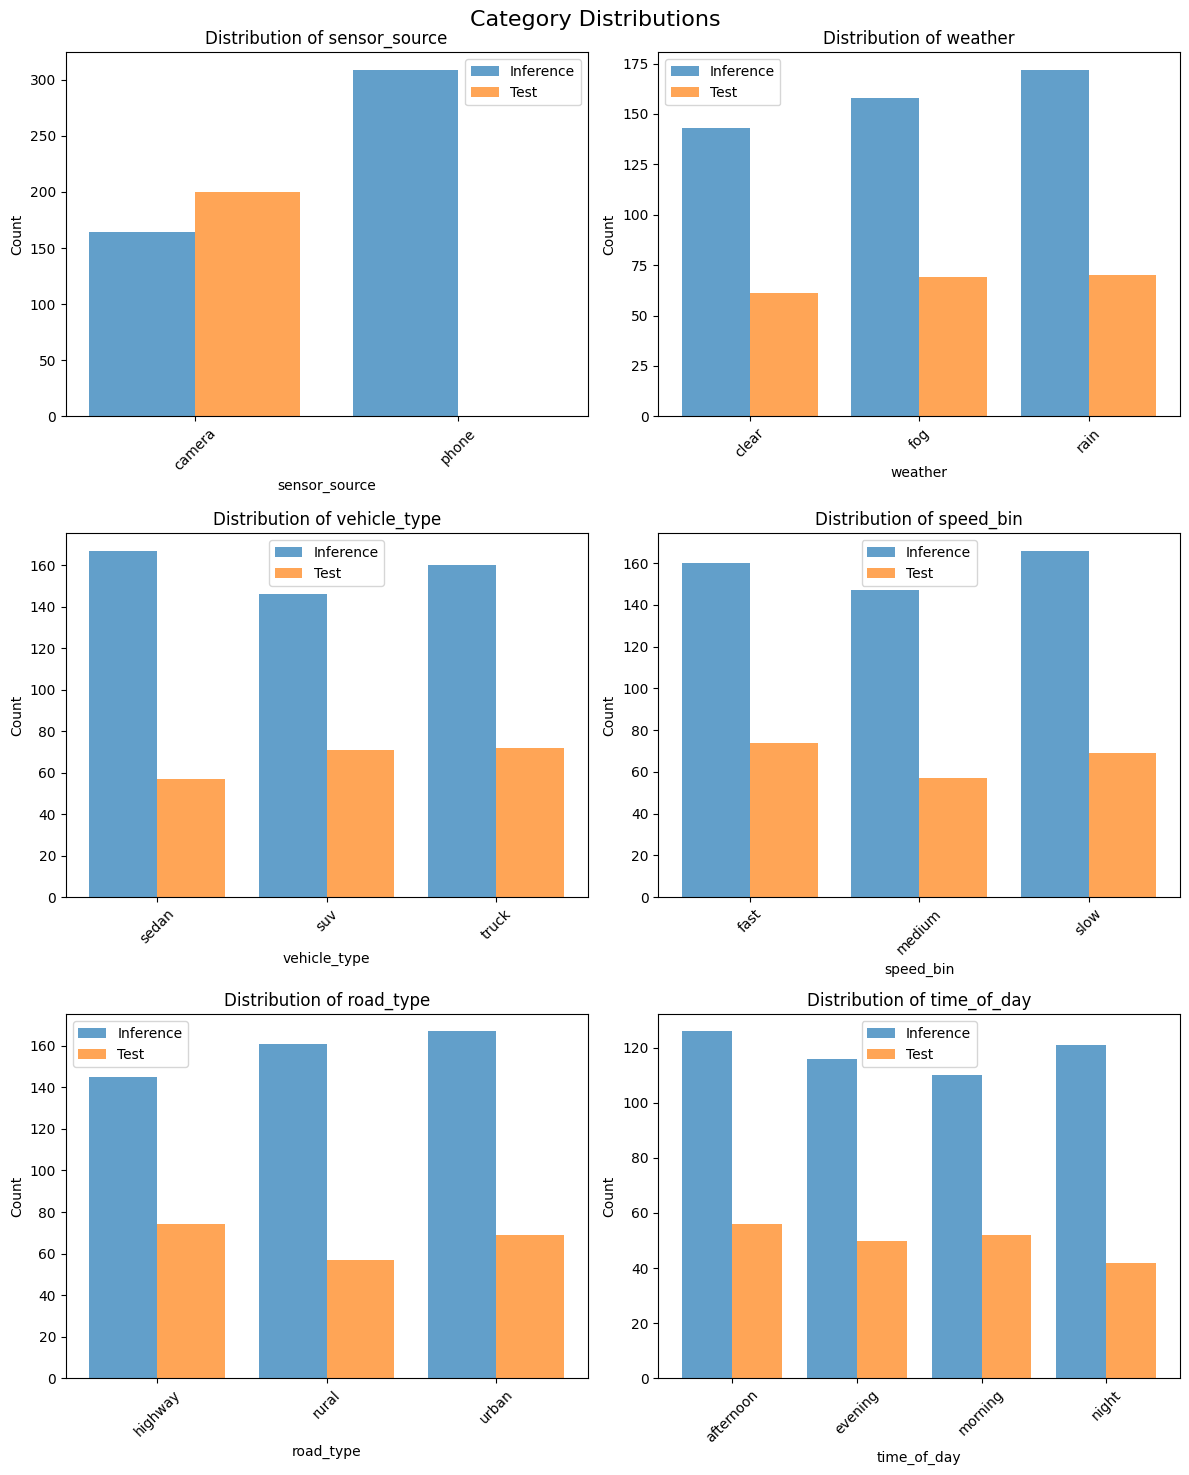

In [13]:
categories = ['sensor_source', 'weather', 'vehicle_type', 'speed_bin', 'road_type', 'time_of_day']
plot_category_distributions(df_inf, df_test, categories, ("Inference", "Test"))

#### Numeric features:

In [14]:
def compare_boxplots(df1, df2, features, labels, figure_title="Numerical Boxplot"):
    n = len(features)
    cols = 2
    rows = (n + 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
    axes = axes.flatten()
    
    for i, feature in enumerate(features):
        ax = axes[i]
        ax.boxplot([df1[feature], df2[feature]], labels=labels)
        ax.set_title(feature)
    
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
        
    fig.suptitle(figure_title, fontsize=16)

    plt.tight_layout()
    plt.show()

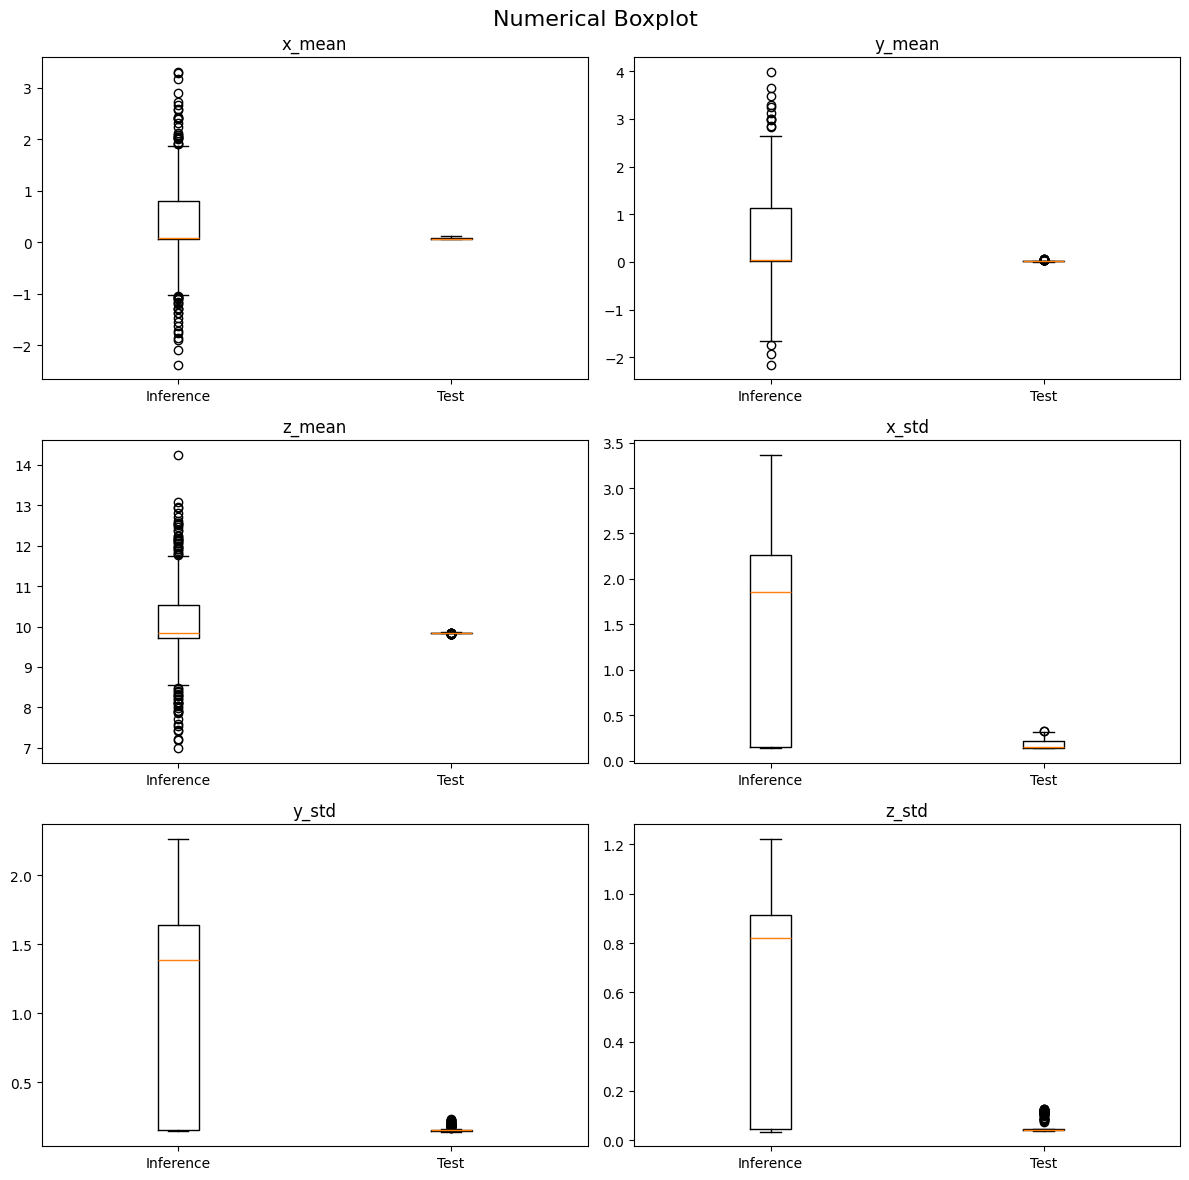

In [15]:
compare_boxplots(df_inf, df_test, ["x_mean", "y_mean", "z_mean", "x_std", "y_std", "z_std"], ['Inference', 'Test'])

### Preliminary conclusion
From the two visualizations we can already observe two findings:
1. Most of the intersting categories are evenly distributed, except from "sensor_source" category. In "sensor_source" category, we can see a clearly uneven distribution, where in test data we have 0 samples from "phone" category, while in inference the distribution of "phone" and "camera" is roughly equal.
2. There is also a noticable difference in distribution of basic numerical features: while in test set x, y values range is around 0, in inference we can see much higher values. We can also learn that the inference data is much "noisy" than the test data.



Let's check if the same distribution is present in the training set:

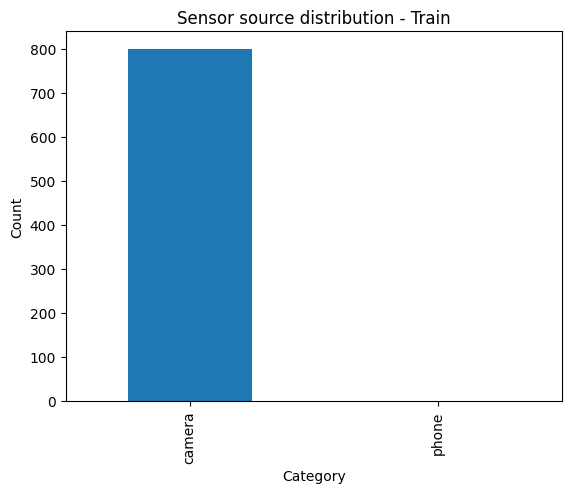

In [43]:
df_train = pd.read_csv("data/train.csv")
df_train['sensor_source'].value_counts().reindex(df_inf['sensor_source'].unique(), fill_value=0).plot(kind='bar')
plt.title('Sensor source distribution - Train')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

Next step (after we know the model was not trained on phone samples) is trying to understand if there is a correlation between "sensor_source" to the behavior of the numerical signals.

In [16]:
def boxplot_by_category(df, value_cols, category_col, figure_title, colors=None, figsize=(8, 6)):
    n = len(value_cols)
    cols = 2  # plots per row
    rows = (n + 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols*figsize[0], rows*figsize[1]))
    axes = axes.flatten()
    
    for i, col in enumerate(value_cols):
        color = colors[i] if colors and i < len(colors) else "skyblue"
        df.boxplot(column=col, by=category_col, ax=axes[i], patch_artist=True,
                   boxprops=dict(facecolor=color))
        axes[i].set_title(f'{col} Distribution by {category_col}')
        axes[i].set_xlabel(category_col)
        axes[i].set_ylabel(col)
    # Hide unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.suptitle(figure_title, fontsize=16)  # remove pandas default title
    plt.tight_layout()
    plt.show()

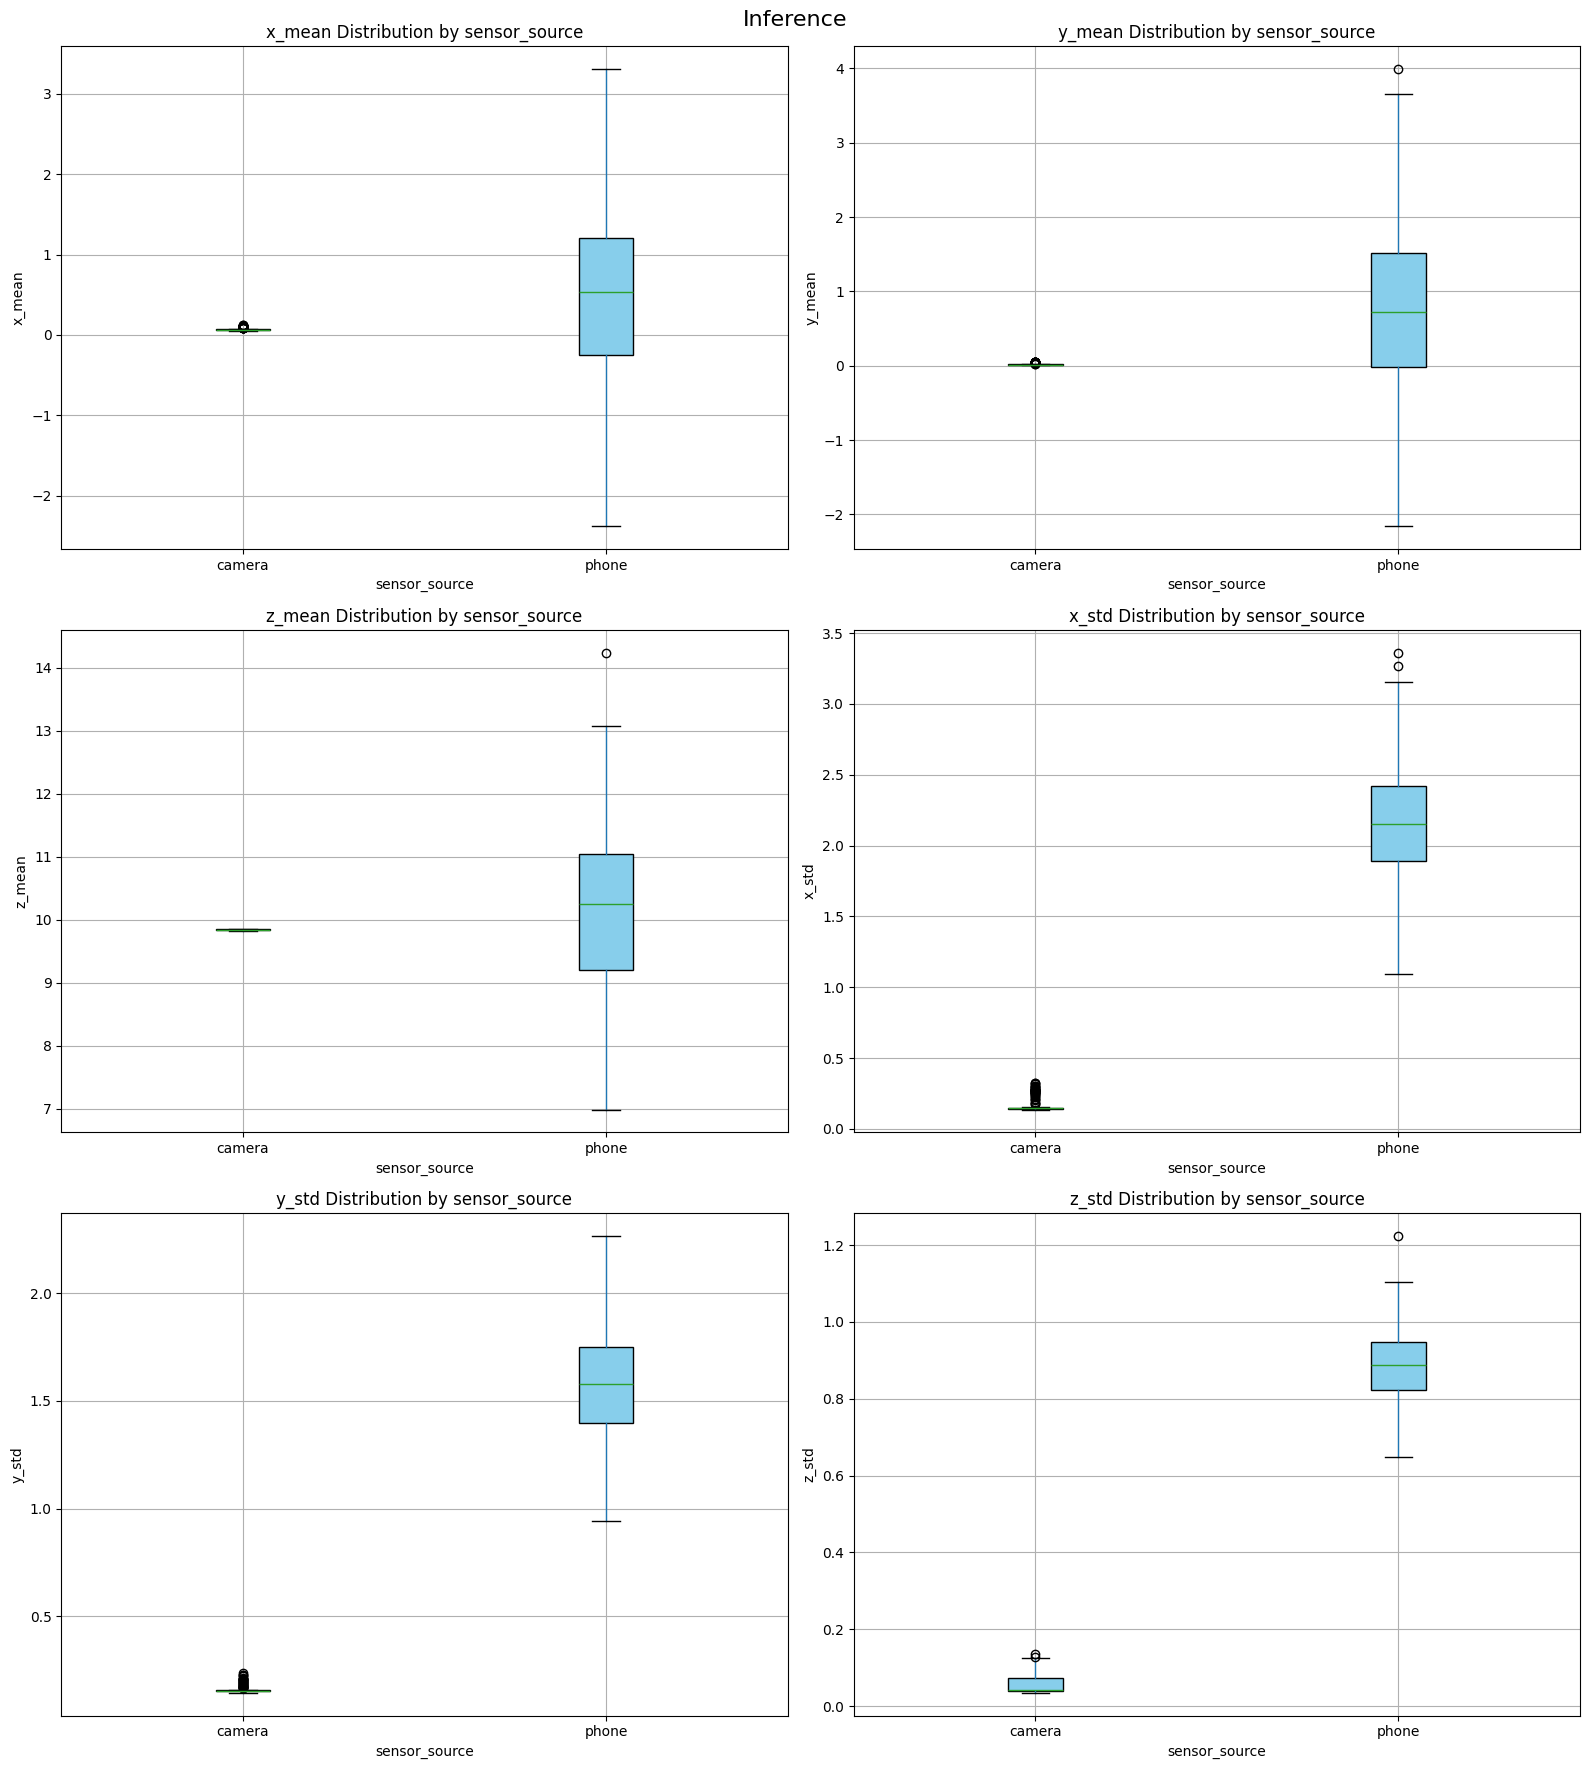

In [17]:
boxplot_by_category(df_inf, ["x_mean", "y_mean", "z_mean", "x_std", "y_std", "z_std"], "sensor_source", "Inference")

### Data distribution conclusion
- Is there anything in the data that might explain differences in behavior?
    ##### ✅ Answer: now we can clearly see a direct correlation between data sensor_source to the numerical signal values. While in "camera" data signals are cleaner and more stable, in "phone" samples the data is noisier and also on a different scale. Since the model was trained only on "camera" samples, this explains the performance drop when processing inference data that comes primarily from the "phone" sensor source.



&emsp;

## Patterns and Trends

For this task, I will split the data into two types: "camera" and "phone". The isolation is required here since we know that our model was trained on "camera" samples only, and its predictions on "phone" samples are not accurate.


In [18]:
df_inf_with_labels = df_inf.copy()
df_inf_with_labels = df_inf_with_labels.merge(labels, on='sample_id', how='left')
df_inf_with_labels["pred_label"] = preds
df_inf_with_labels['correct'] = df_inf_with_labels['label'] == df_inf_with_labels['pred_label']
df_inf_phones_only = df_inf_with_labels[df_inf_with_labels['sensor_source'] == 'phone']
df_inf_cameras_only = df_inf_with_labels[df_inf_with_labels['sensor_source'] == 'camera']

#### Confusion matrix
This confusion matrix table will help us to understand the distribution of the predicted classes

In [19]:
def vis_confusion_matrix(df, all_labels, title):
    conf_mat = pd.crosstab(df['label'], df['pred_label'])
    conf_mat = conf_mat.reindex(index=all_labels, columns=all_labels, fill_value=0)
    
    fig, ax = plt.subplots()
    im = ax.imshow(conf_mat, cmap='Blues')
    
    # Show numbers
    for i in range(len(all_labels)):
        for j in range(len(all_labels)):
            ax.text(j, i, conf_mat.iloc[i,j], ha='center', va='center', color='black')
    
    ax.set_xticks(np.arange(len(all_labels)))
    ax.set_yticks(np.arange(len(all_labels)))
    ax.set_xticklabels(all_labels)
    ax.set_yticklabels(all_labels)
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('GT Label')
    ax.set_title(title)
    plt.show()

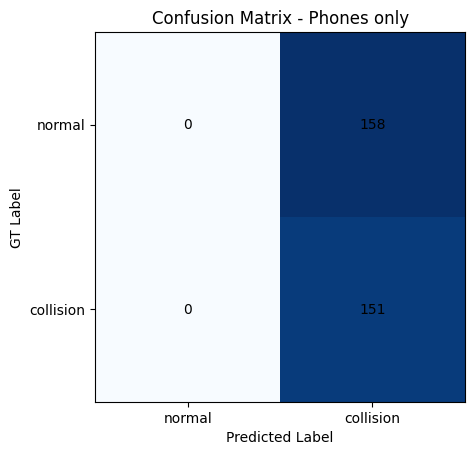

In [20]:
vis_confusion_matrix(df_inf_phones_only, df_inf_phones_only['label'].unique(), "Confusion Matrix - Phones only")

From the confusion matrix, we can observe an **interesting insight** - we see that our model predict the same category - "collision" for all samples.

&emsp;

Now let's try to understand why, for this we need to inspect the raw IMU signals for phone samples in both "normal" and "collision" scenarios:

#### Phone - "normal"

In [21]:
df_inf_with_labels[(df_inf_with_labels['sensor_source'] == 'phone') & (df_inf_with_labels['label'] == 'normal')][['sample_id']].head(1)

,sample_id
2,01fb46f8-2dc1-4bd3-a823-252a87c3bd03


##### IMU signal graph for sample "01fb46f8-2dc1-4bd3-a823-252a87c3bd03"

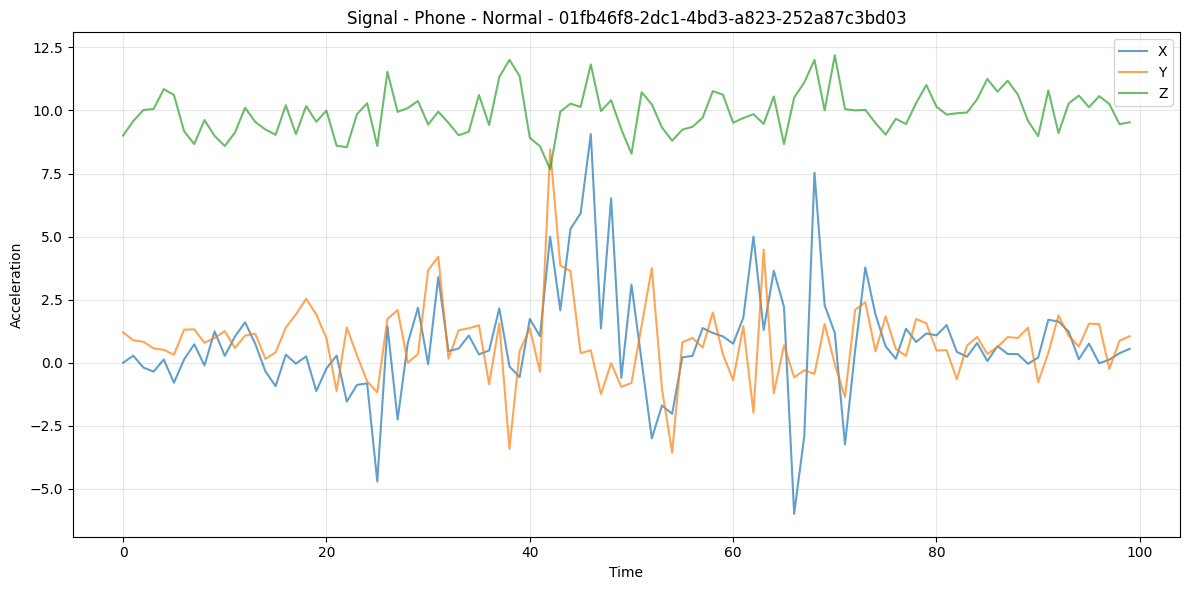

In [58]:
sample_id = "01fb46f8-2dc1-4bd3-a823-252a87c3bd03"
signal, _ = load_and_process_sample(f'inference/{sample_id}')
plot_signal(signal, f'Phone - Normal - {sample_id}')

#### Phone - "collision"

In [23]:
df_inf_with_labels[(df_inf_with_labels['sensor_source'] == 'phone') & (df_inf_with_labels['label'] == 'collision')][['sample_id']].head(1)

,sample_id
4,02d8b8af-803d-4898-9eb5-51b771e5f2d9


##### IMU signal graph for sample "02d8b8af-803d-4898-9eb5-51b771e5f2d9":

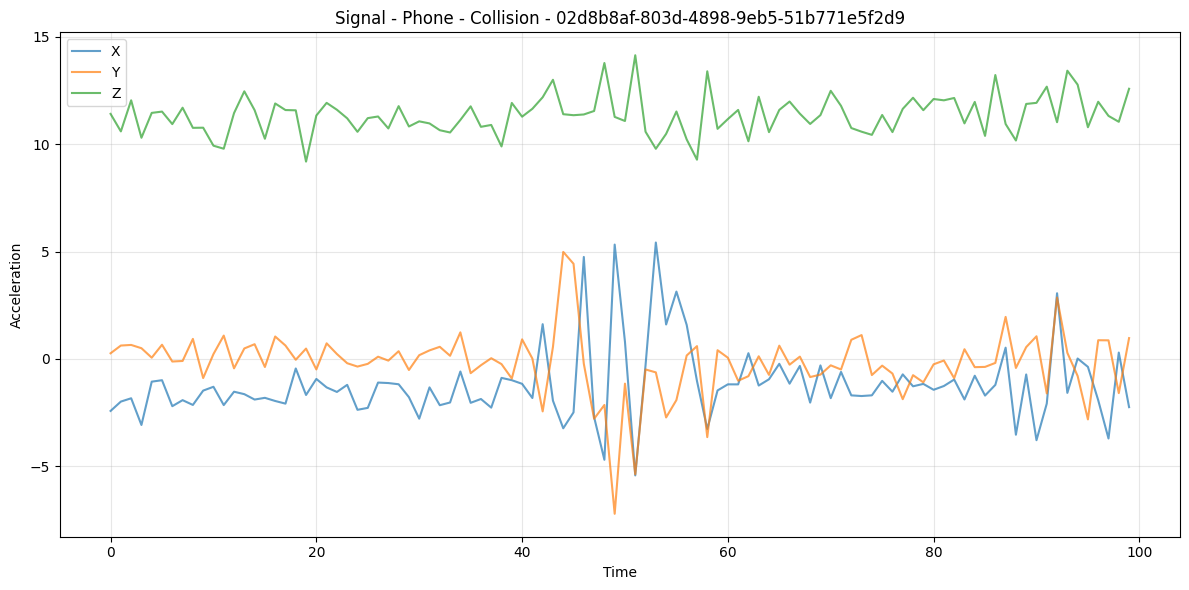

In [56]:
sample_id = "02d8b8af-803d-4898-9eb5-51b771e5f2d9"
signal, _ = load_and_process_sample(f'inference/{sample_id}')
plot_signal(signal, f'Phone - Collision - {sample_id}')

While examining the raw IMU data from a "phone" signal, we can observe regular spikes even in normal scenarios -> which could explain our finding from the confusion matrix -> our model interpret each phone spike as a "collision". In the other hand, we know that for the camera samples, we could find such spikes only in specific moments, which are the actual collision spikes.

&emsp;

#### Numerical features behavior - "collision" vs "normal"
We know that all features in the trained data are based on the raw IMU XYZ data, so we can examine how the distribution of some interesting signals is different for "collision" and "normal" scenarios, and probably affect the model decision making:

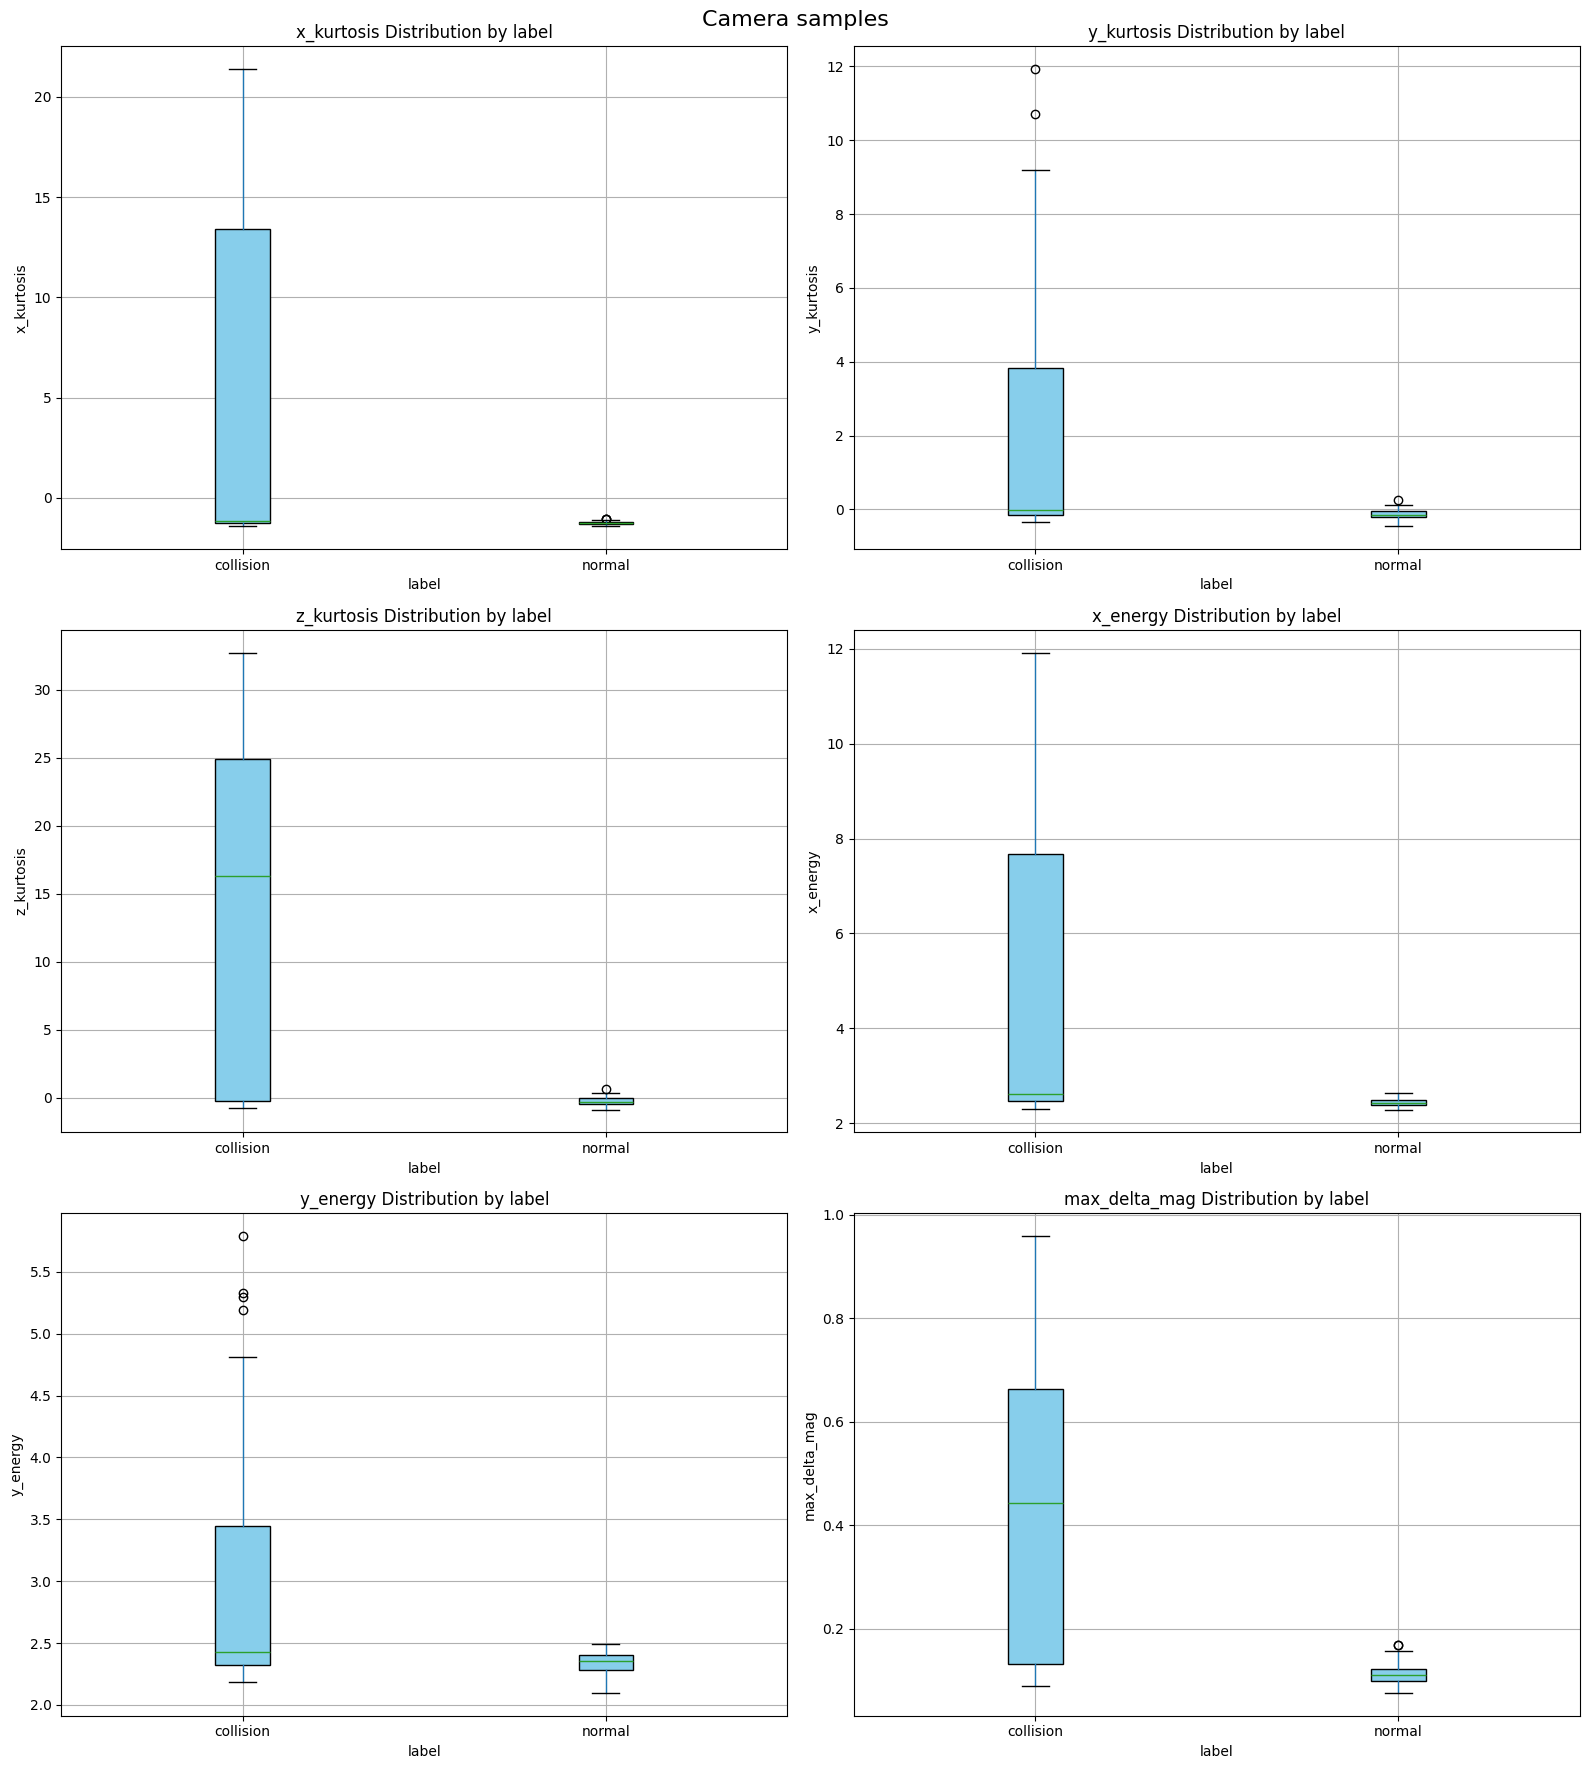

In [25]:
normal_df = df_inf_cameras_only[df_inf_cameras_only['label'] == 'normal']
collision_df = df_inf_cameras_only[df_inf_cameras_only['label'] == 'collision']

boxplot_by_category(df_inf_cameras_only, ["x_kurtosis", "y_kurtosis", "z_kurtosis", "x_energy", "y_energy", "max_delta_mag"], "label", "Camera samples")

&nbsp;
#### When the model fails (for camera samples)?

We also want to understand when the model fails (for camera samples only), let's examine it:

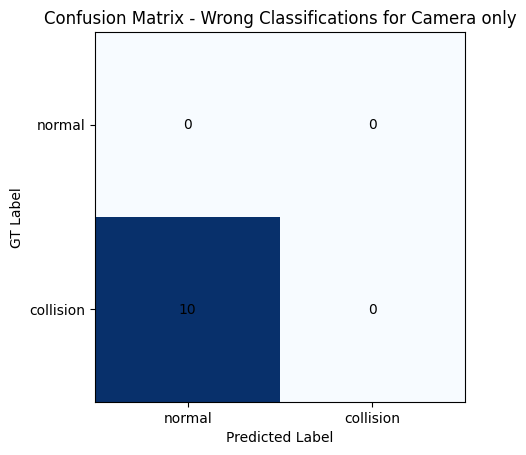

In [29]:
negative_df_cameras_only = df_inf_cameras_only[df_inf_with_labels['correct'] == 0]
vis_confusion_matrix(negative_df_cameras_only, df_inf_with_labels['label'].unique(), "Confusion Matrix - Wrong Classifications for Camera only")

In [30]:
negative_df_cameras_only[['sample_id']].head(2)

,sample_id
107,38444980-c39e-489f-aece-edc52267fce7
178,5c334bfa-9a5a-4ca8-826a-e9110f7bd972


##### IMU signal graph for sample "38444980-c39e-489f-aece-edc52267fce7":

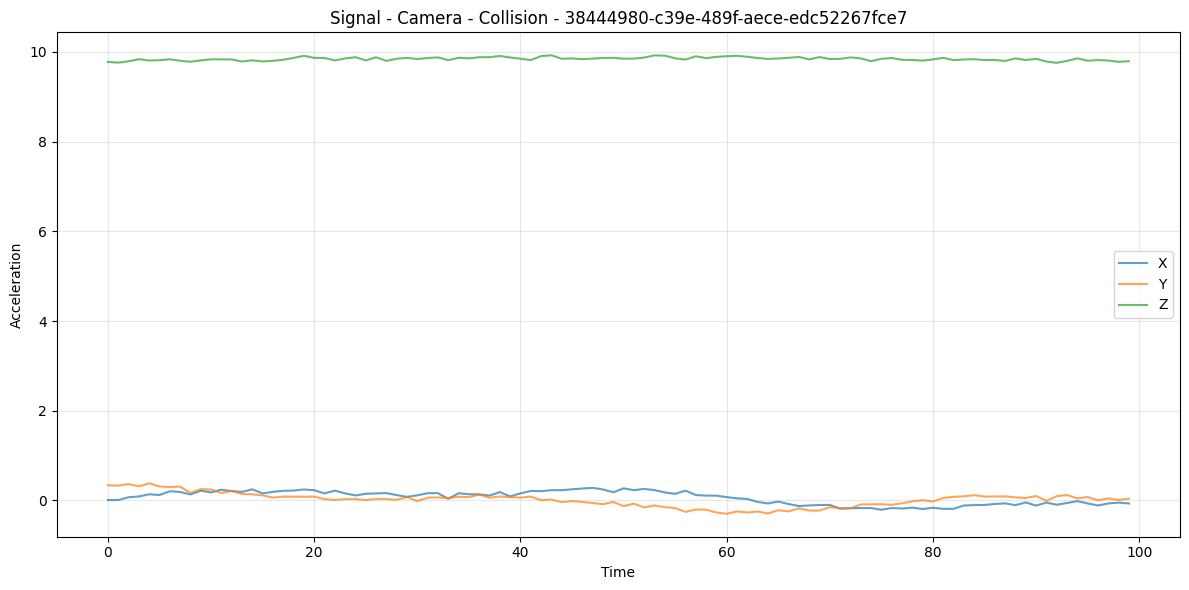

In [60]:
sample_id = "38444980-c39e-489f-aece-edc52267fce7"
signal, _ = load_and_process_sample(f'inference/{sample_id}')
plot_signal(signal, f'Camera - Collision - {sample_id}')

##### IMU signal graph for sample "5c334bfa-9a5a-4ca8-826a-e9110f7bd972":

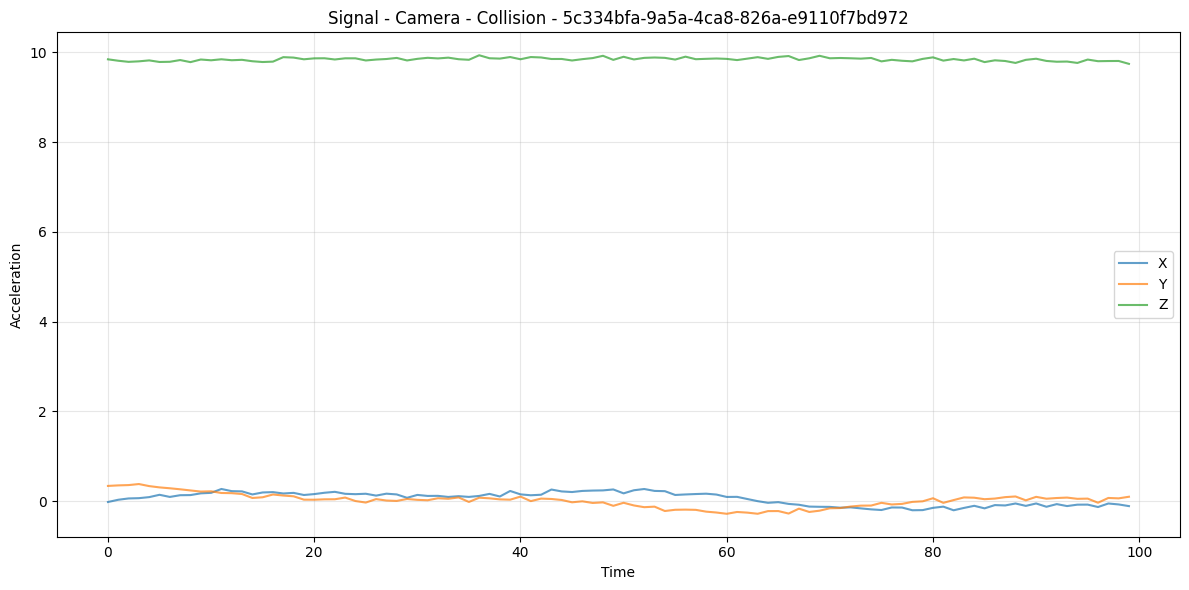

In [59]:
sample_id = "5c334bfa-9a5a-4ca8-826a-e9110f7bd972"
signal, _ = load_and_process_sample(f'inference/{sample_id}')
plot_signal(signal, f'Camera - Collision - {sample_id}')

From the inference data, we learn that our model failed to predict only 10 "camera" instances from "collision" scenario (which means all "normal" scnearios of camera samples were detected well), and from the visualizations of the raw IMU data of the specific samples, we can see very solid signals, without no spikes. These signals are very similar to "normal" scenario signals, so it could explain why our model thinks these are "normal" and not "collision".

### Patterns and trends conclusions
- Can you identify patterns or trends related to when the model succeeds or fails?
    ##### ✅ Answer: Yes, we can divide it to two - "camera" and "phone" trends - for "phone" samples, our model always predict the sample as "collision", this is because our model is sensitive to spikes in the signal, and since "phone" samples contains spikes and large scale numbers regularly (even in "normal" scenarios), our model is not able to distinguish between "collision" and "normal" and thinks all the samples are from "collision" type. For "camera" samples, our model detects correctly "normal" scenarios, but sometimes fails to detect "collision" scenarios, since the signal on these specific scenarios is solid, without no sudden spikes (which are usually indicative of collisions).

  &thinsp;

- Are there signals or features that seem to affect the model’s reliability?

    ##### ✅ Answer: Yes, currently all samples from the "phone" sensor_source are not interpreted well by the model. Since the model was not trained on such samples, its predictions for these cases are unreliable and cannot be trusted. Sudden changes in certain signals (x_kurtosis, y_kurtosis, z_kurtosis, max_delta_mag,..) likely indicate a collision, while in "phone" samples such signals can be dominant in both "normal" and "collision" scenarios, which affects the reliability of the model for these samples.

&emsp;

## Short and long term solutions

- What could be done in the short term to handle the current situation?

    ##### ✅ Answer: Since we know that "phone" data is fundamentally different from "camera" data, and the model was trained only on 'camera' data, we can apply few workarounds, but they won't fully address the root cause of the problem. The suggested workarounds are mainly involve applying post processing techniques and heuristics, without the need to retrain the model.

  Suggested workarounds (without retraining the model):
  1. Our model provides prediction probabilities, so we can analyze the confidence levels to determine when its predictions for "collision" classification can be trusted. After identifying the desired confidence level, we can add a post processing block for all "phone" samples, and approve the "collision" prediction only if the probability threshold exceeds a threshold X.
 
  2. Using heuristic based rules, we can find few dominant thresholds from our feature vector and include them in the post processing block, to fix wrong classifications on "phone" samples (like trying to find a threshold for a signal or combination of signals where for example we can eliminate false "collision" classifications).

- What are potential long-term steps to improve model performance in similar scenarios?

    ##### ✅ Answer: For a more robust and long term solution, we should retrain the model on both camera and phone samples. Currently, we face a domain drift issue because the model has learned only camera patterns. To address this issue, the model must also learn phone data patterns - camera data is cleaner and more structured, with spikes clearly indicating collisions, whereas phone data is noisier and sudden spikes do not necessarily correspond to collisions.

  Suggested solutions:
  1. Create two separate models to handle different sensor sources - each model will be trained on data from a specific sensor source (camera, phone) and will be dedicated to it. In this solution, when we get an inference, we will identify the sensor source and then use the relevant model. This solution could be pretty easy to implement but it becomes harder to maintain various models as the number of sensors grows, since each model requires separate training and maintenance (BTW, in some conditions this solution could also serve us as a short term solution - if we already have "phone" data samples and enough time to train a new model for handling phone samples).
 
     
  2. Create a unified model to handle multiple sensor sources - in this solution a single model is trained on a combined dataset that includes all sensor sources (both camera and phone in our case). This requires encoding the sensor source during training so the model can learn to differentiate between them. This solution is more robust and scalable, particularly when managing a larger variety of sensor sources.

&emsp;

## Additional observations


- What would you want to explore further if given more time or data?

    ##### ✅ Answer: Yes there are few thing I would like to explore if given more data and time:
   1. It could be interesting to investigate why "phone" signals are so noisy and whether this can be addressed/improved. It would also be useful to compare the IMU signal to a real visual video, to see if we can learn something about the behavior of the IMU signal comparing to the real world scenario (mainly in phone samples, which is more difficult to distinguish between "normal" and "collision" signals).
 
      
  2. It could be interesting to examine if there is a different/unique behavior of the IMU signal across different vehicle types (sedan, truck etc.), especially in collision scenarios. Maybe we could extract new features using these insights.
 
  
  3. While testing the inference performance, we noticed that 10 "collision" samples from camera sensor were detected as "normal". While observing the IMU signal for these samples, we see that the signals are solid and clean (without no spikes). This behavior is very suspicious, it would be interesting to watch the visual video for these specific samples, and determine whether the annotations are wrong, or whether the IMU signals are unreliable on these samples.

- What assumptions did the model rely on during training — and are they still valid?

    ##### ✅ Answer: The assumptions the model rely on during training are:
  1. The model assumed that sudden peaks in certain signals always indicate a collision event. However, we have observed that this assumption is not necessarily true. In phone samples, signal peaks and spikes can occur even in normal scenarios. The model should be able to distinguish between noise and actual collisions, but currently every spike is interpreted as a collision.
 
  2. The model assumed that "normal" scenarios are mainly characterized by very stable and low signals (around zero). This is not necessarily true - in phone data samples we can observe higher signal volumes even in normal scenarios.